# pyPanair Tutorial#3 Wing/body model
In this tutorial we will perform an analysis of a wing/body configuration.  

The model is based on the [AGARD-B model<sup>1</sup>](http://www.uwal.org/download/documents/agardcalmodelspecs.pdf)  
(The sting is not included, and the aft-body is slightly modified for this tutorial.)
![uppersurface]()

## 1.Defining the geometry

The model will be composed from eight networks:    

1. Wing  
2. Nose  
3. Mid-body
4. Aft-body
5. Body base
6. Wing wake
7. Body base wake
8. Body wake

The geometry of the model is defined in terms of the body diameter $D$.  
For simplicity, it will be set at $D=1$.

### 1.1 Wing

First, initialize a `LaWGS` object.

In [1]:
from pyPanair.preprocess import wgs_creator
wgs = wgs_creator.LaWGS("agardb_mod")

Next, we will create a `Line` object that defines the airfoil at the wing root.  
The airfoil of the AGARD-B model is a circular-arc airfoil of 4% thickness.  
A csv file has been prepared in advance. 
The coordinates in `circular_arc.csv` are normalized, so when using the `read_airfoil` function, we shall set the `expantion_ratio` at `2.598`.
By doing so, the x & z-axis coordinates of the resulting airfoil will be multiplied by `2.598`.

In [2]:
root_airfoil = wgs_creator.read_airfoil("circular_arc.csv", span_pos=0.5, expansion_ratio=2.598)

<IPython.core.display.Javascript object>


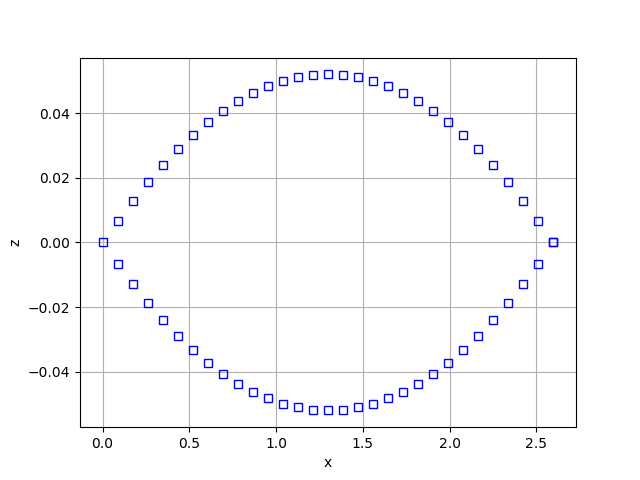

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.plot(root_airfoil[:,0], root_airfoil[:,2], "s", mfc="None", mec="b")
plt.xlabel("x")
plt.ylabel("z")
plt.grid()
plt.show()

Since the apex of the nose is the origin, we'll need to shift the coordinates of the `root_airfoil`, so that the x-coordinate of its LE becomes `4.5`.
This will be done by with the `shift` method.

In [4]:
root_airfoil = root_airfoil.shift((4.5, 0., 0.))

Next, we define the tip chord. 
The tip of the wing is a point, but when defining it, we need to use the same number of points we used to define the wing root.
This means that we need to define a `Line` with `61` identical points.  

This can be easily done by using the `replace` method. By typing

In [5]:
tip_airfoil = root_airfoil.replace(x=7.098, y=2., z=0.)

a copy of `root_airfoil` will be created. 
The xyz coordinates of each point in the copy will be replaced by `2.598`, `2.`, and `0.`, respectively.

The wing `Network` will be created and registered to `wgs` in the same way as tutorials 1 and 2.  

In [6]:
wing = root_airfoil.linspace(tip_airfoil, num=30)
wgs.append_network("wing", wing, 1)

<IPython.core.display.Javascript object>


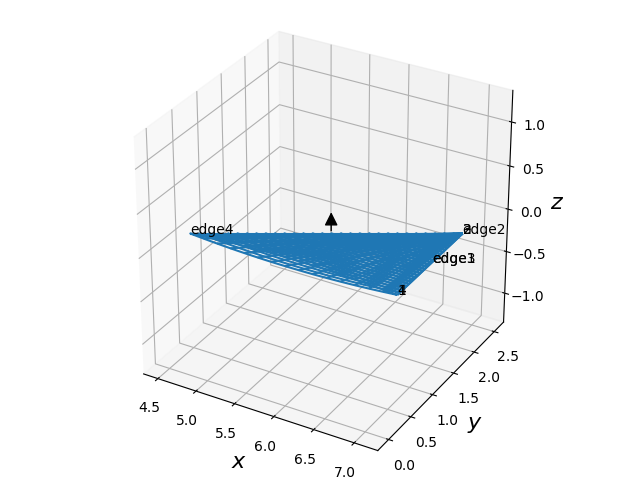

In [7]:
wing.plot_wireframe()

### 1.2 Nose+Fore-body

The nose profile is described by
$$r=\frac{x}{3}[1-\frac{1}{9}(\frac{x}{D})^2+\frac{1}{54}(\frac{x}{D})^3]$$
$r$ is the radius and $x$ is the x-coordinate.

The fore-body is a cylinder with a radius of $D$.

First, we define the `Line` for the nose and fore-body at `z=0.`.

In [8]:
import numpy as np

n_nose = 8
x_nose = np.linspace(0., 3., num=n_nose)
y_nose = x_nose/3 * (1 - 1/9*(x_nose)**2 + 1/54*(x_nose)**3)
nose_line = wgs_creator.Line(np.zeros((n_nose, 3)))
nose_line[:,0] = x_nose
nose_line[:,1] = y_nose

fbody_p1 = wgs_creator.Point(nose_line[-1])
fbody_p2 = fbody_p1.replace(x=4.5)
fbody_line = fbody_p1.linspace(fbody_p2, num=4)

nose_fbody_line = nose_line.concat(fbody_line)

Other `Lines` that define the nose and fore-body will be created by rotating `fbody_line`.  
The upper/lower surfaces can be created by typing

In [9]:
nose_fbody_up = list()
for i in np.linspace(0, 90, 7):
    line = nose_fbody_line.rotx(rotcenter=nose_fbody_line[0], angle=i)
    nose_fbody_up.append(line)
nose_fbody_up = wgs_creator.Network(nose_fbody_up)

nose_fbody_low = list()
for i in np.linspace(-90, 0, 7):
    line = nose_fbody_line.rotx(rotcenter=nose_fbody_line[0], angle=i)
    nose_fbody_low.append(line)
nose_fbody_low = wgs_creator.Network(nose_fbody_low)

wgs.append_network("n_fb_up", nose_fbody_up, 1)
wgs.append_network("n_fb_low", nose_fbody_low, 1)

<IPython.core.display.Javascript object>


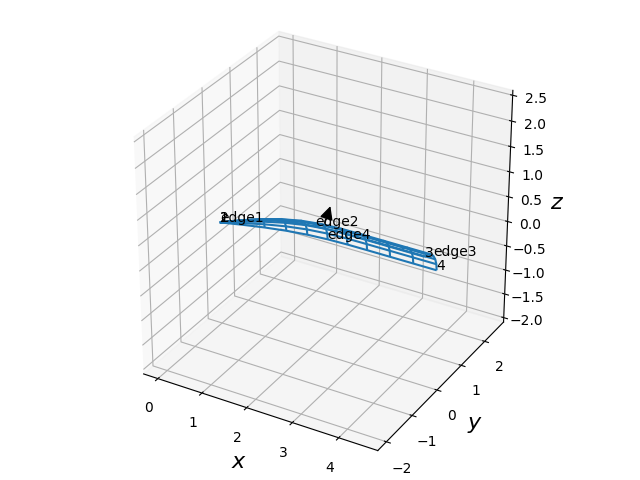

In [10]:
nose_fbody_up.plot_wireframe()

<IPython.core.display.Javascript object>


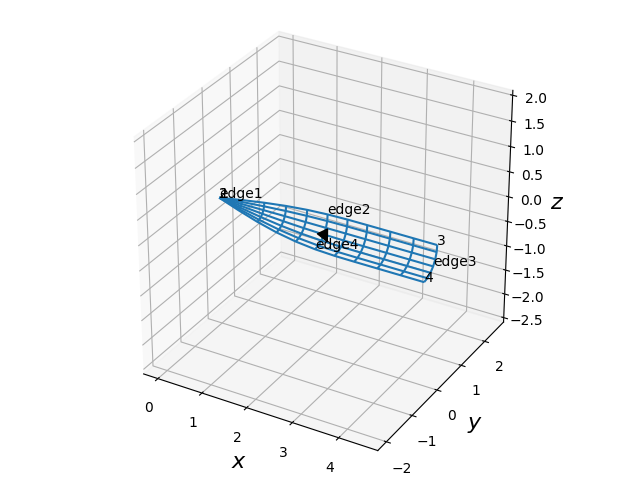

In [11]:
nose_fbody_low.plot_wireframe()

### 1.3 Mid-body

The mid-body is a cylinder with a hole at the section where the body and wing intersect.  

First, we define the upper surface.

In [12]:
wingroot_up, wingroot_low = root_airfoil.split_half()
mbody_line = wingroot_up.replace(z=0.)

mbody_up = list()
for i in np.linspace(90, 0, 7)[:-1]:
    line = mbody_line.rotx((0,0,0), angle=i)
    mbody_up.append(line)
mbody_up.append(wingroot_up)
mbody_up = wgs_creator.Network(mbody_up)
wgs.append_network("mbody_up", mbody_up, 1)

<IPython.core.display.Javascript object>


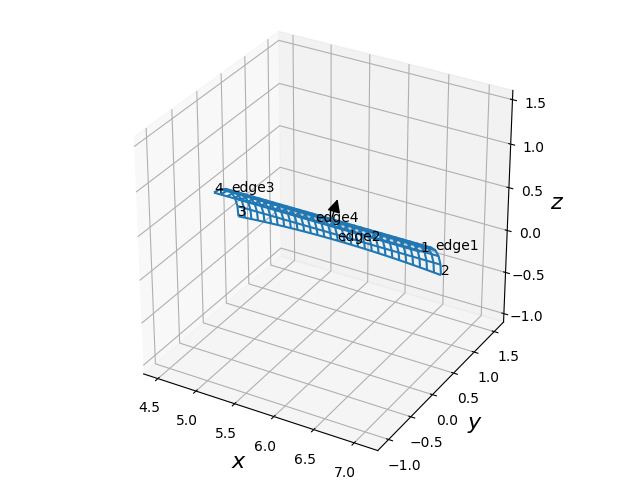

In [14]:
mbody_up.plot_wireframe()

Next, we define the lower surface.

In [15]:
wingroot_low = wingroot_low.flip()
mbody_low = list()
mbody_low.append(wingroot_low)
for i in np.linspace(0, -90, 7)[1:]:
    line = mbody_line.rotx((0,0,0), angle=i)
    mbody_low.append(line)
mbody_low = wgs_creator.Network(mbody_low)
wgs.append_network("mbody_low", mbody_low, 1)

<IPython.core.display.Javascript object>


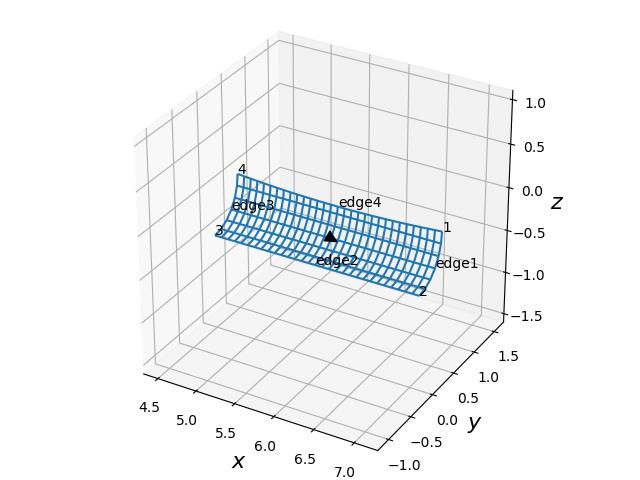

In [16]:
mbody_low.plot_wireframe()

In the original AGARD-B model, the aft-body is a cylinder.  
However, in this tutorial it will be a circular truncated cone, for the sake of learning how to attach body wakes.  

First, we define the `Line` for the aft-body at `z=0.`.

In [22]:
aft_body_p1 = wgs_creator.Point(root_airfoil[0])
aft_body_p2 = aft_body_p1.shift((1.402, -0.05, 0.))
aft_body_line = aft_body_p1.linspace(aft_body_p2, num=8)

After that, we define the `Networks` for the upper and lower surfaces.

In [25]:
aft_body_up = list()
for i in np.linspace(0, 90, num=7):
    line = aft_body_line.rotx((0,0,0), angle=i)
    aft_body_up.append(line)
aft_body_up = wgs_creator.Network(aft_body_up)
wgs.append_network("abody_up", aft_body_up, 1)

<IPython.core.display.Javascript object>


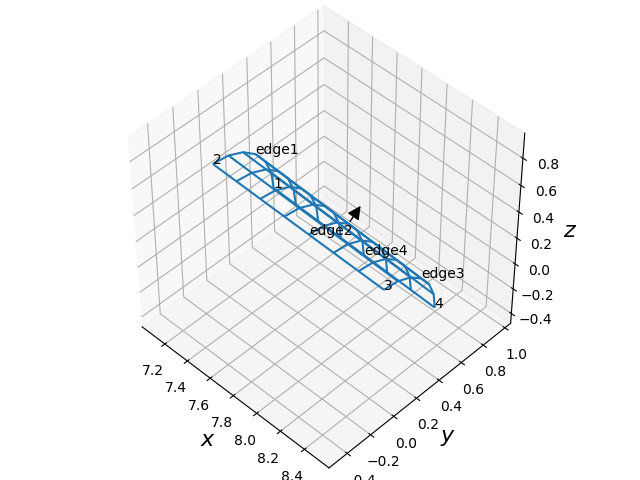

In [26]:
aft_body_up.plot_wireframe()

In [27]:
aft_body_low = list()
for i in np.linspace(-90, 0, num=7):
    line = aft_body_line.rotx((0,0,0), angle=i)
    aft_body_low.append(line)
aft_body_low = wgs_creator.Network(aft_body_low)
wgs.append_network("abody_low", aft_body_low, 1)

<IPython.core.display.Javascript object>


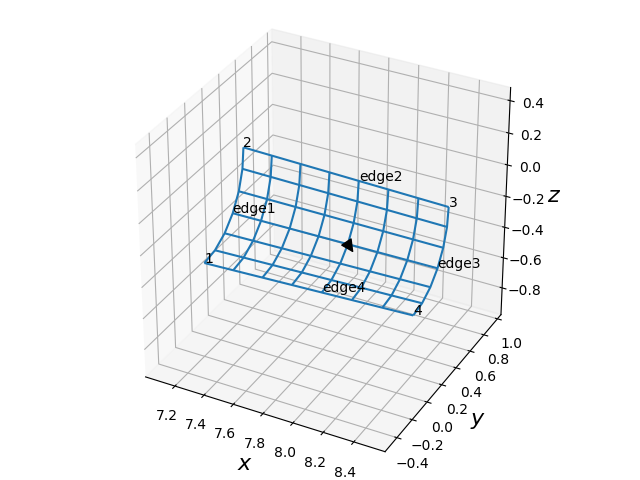

In [28]:
aft_body_low.plot_wireframe()